<a href="https://colab.research.google.com/github/Aldrin-Fanir/Carvana-UNet/blob/main/Carvana_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Library

In [1]:
import copy
import os
import random
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

# Double Convolution

In [2]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding = 1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),\
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv_op(x)

# Downsampling

In [3]:
class DownSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    down = self.conv(x)
    p = self.pool(down)

    return down, p

# Upsampling

In [4]:
class UpSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    x = torch.cat([x1, x2], 1)

    return self.conv(x)

# UNet Architecture

In [5]:
class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.down_convolution_1 = DownSample(in_channels, 64)
    self.down_convolution_2 = DownSample(64, 128)
    self.down_convolution_3 = DownSample(128, 256)
    self.down_convolution_4 = DownSample(256, 512)

    self.bottle_neck = DoubleConv(512, 1024)

    self.up_convolution_1 = UpSample(1024, 512)
    self.up_convolution_2 = UpSample(512, 256)
    self.up_convolution_3 = UpSample(256, 128)
    self.up_convolution_4 = UpSample(128, 64)

    self.output = nn.Conv2d(64, out_channels = num_classes, kernel_size=1)


  def forward(self, x):
    down_1, p1 = self.down_convolution_1(x)
    down_2, p2 = self.down_convolution_2(p1)
    down_3, p3 = self.down_convolution_3(p2)
    down_4, p4 = self.down_convolution_4(p3)

    b = self.bottle_neck(p4)

    up_1 = self.up_convolution_1(b, down_4)
    up_2 = self.up_convolution_2(up_1, down_3)
    up_3 = self.up_convolution_3(up_2, down_2)
    up_4 = self.up_convolution_4(up_3, down_1)

    out = self.output(up_4)

    return out


# Test Model with dummy object

In [6]:
input_image = torch.rand((1, 3, 512, 512))
model = UNet(3, 10)
output = model(input_image)
print(output.size())

torch.Size([1, 10, 512, 512])


# Loading the Carvana Dataset

# Drive Mount : Import Google Drive

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Directory of Images and Masks

In [54]:
root_path = '/content/drive/MyDrive/UNet/data'

In [55]:
print("Is path correct?", os.path.exists(root_path))

Is path correct? True


# Carvana Dataset

In [71]:
class CarvanaDataset(Dataset):
  def __init__(self, root_path, limit = None):
    self.root_path = root_path
    self.limit = limit

    self.images = sorted([root_path + "/train/" + i for i in os.listdir(root_path + "/train")]) [:self.limit]
    self.masks = sorted([root_path + "/train_masks/" + i for i in os.listdir(root_path + "/train_masks")]) [:self.limit]

    self.transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

    if self.limit is None:
      self.limit = len(self.images)


  def __getitem__(self, index):
    img = Image.open(self.images[index]).convert("RGB")
    mask = Image.open(self.masks[index]).convert("L")

    return self.transform(img), self.transform(mask)


  def __len__(self):
    return min(len(self.images), self.limit)

# Is Dataset load Properly!!

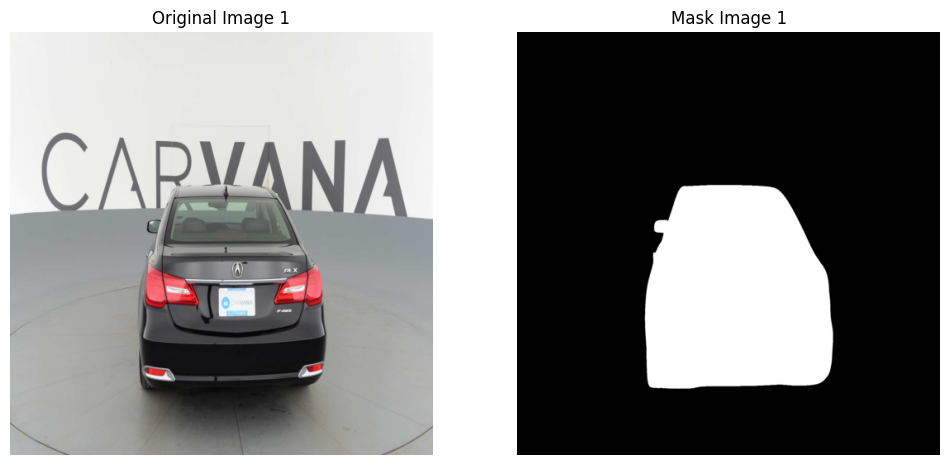

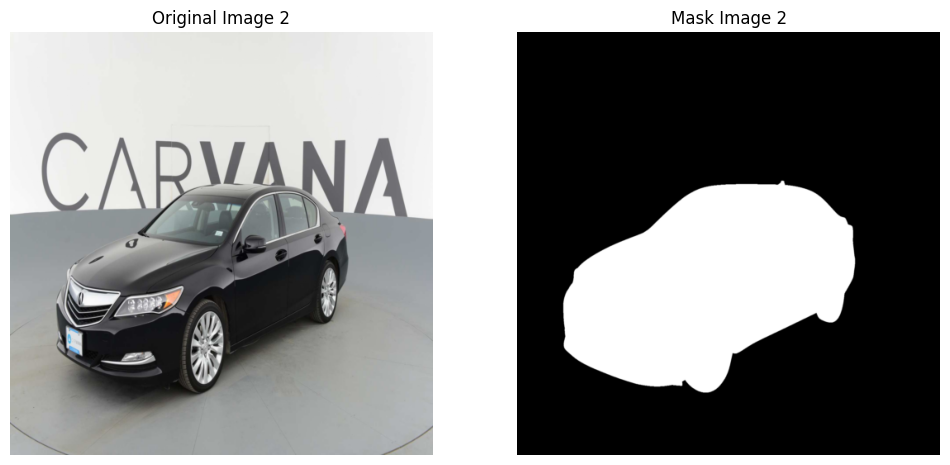

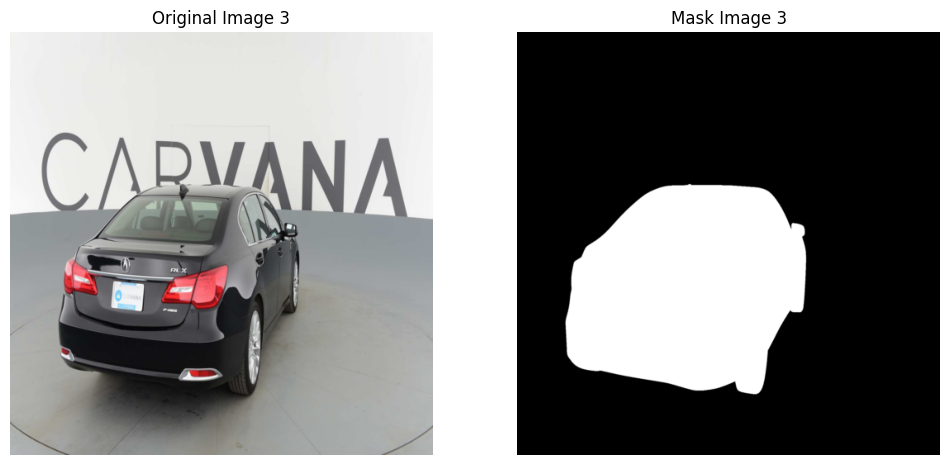

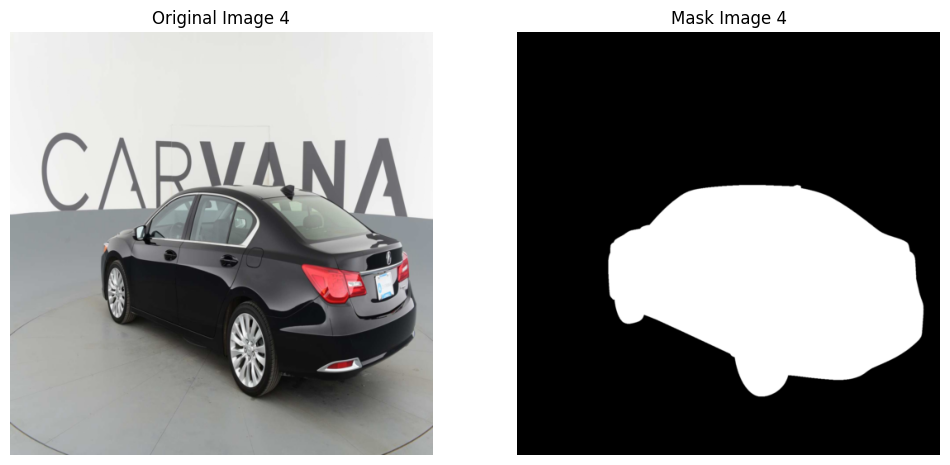

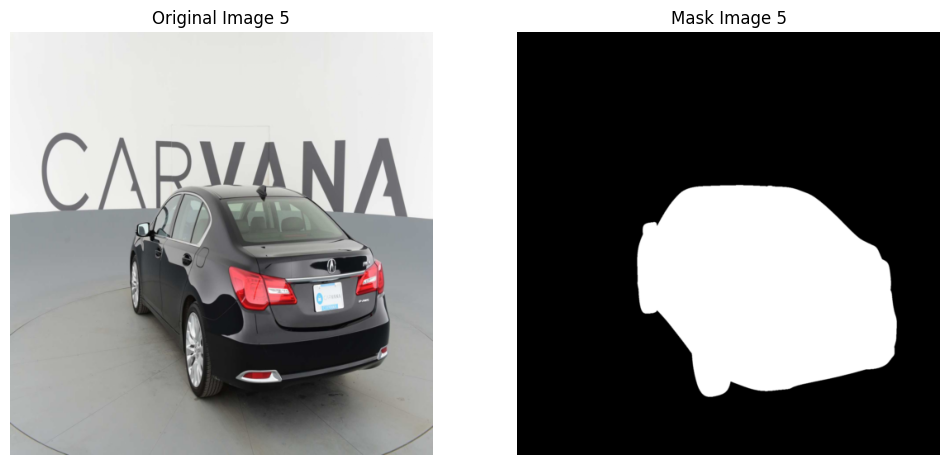

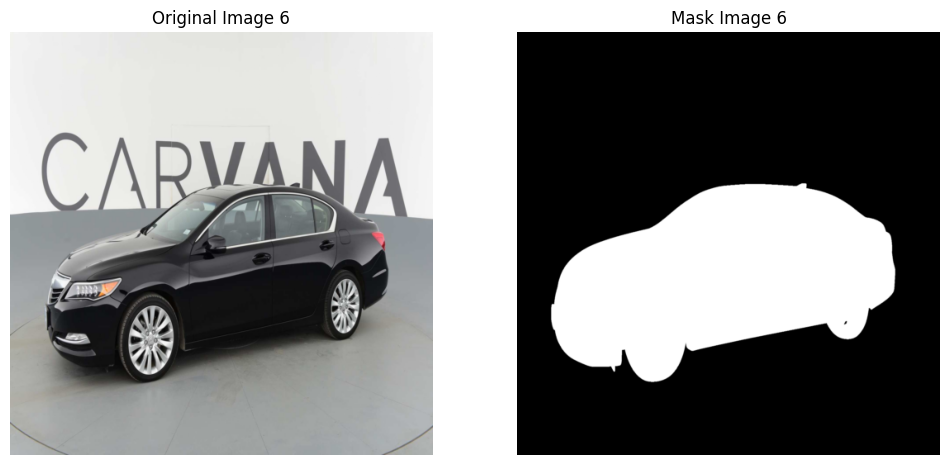

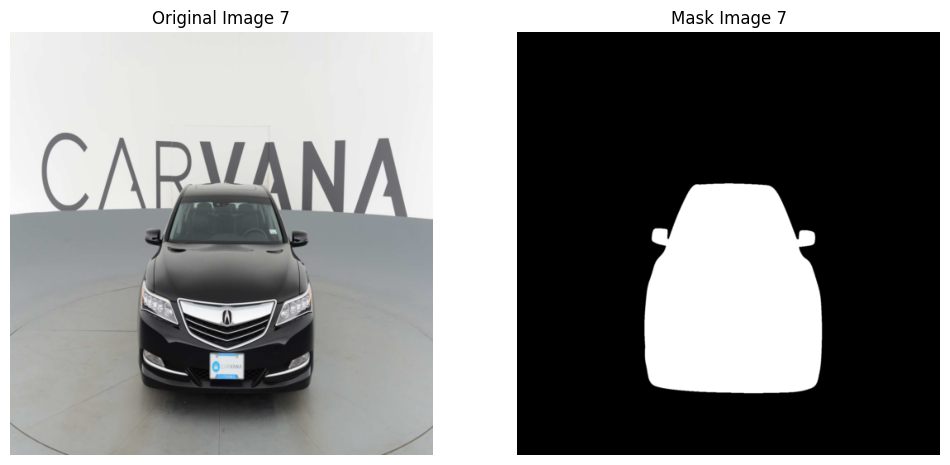

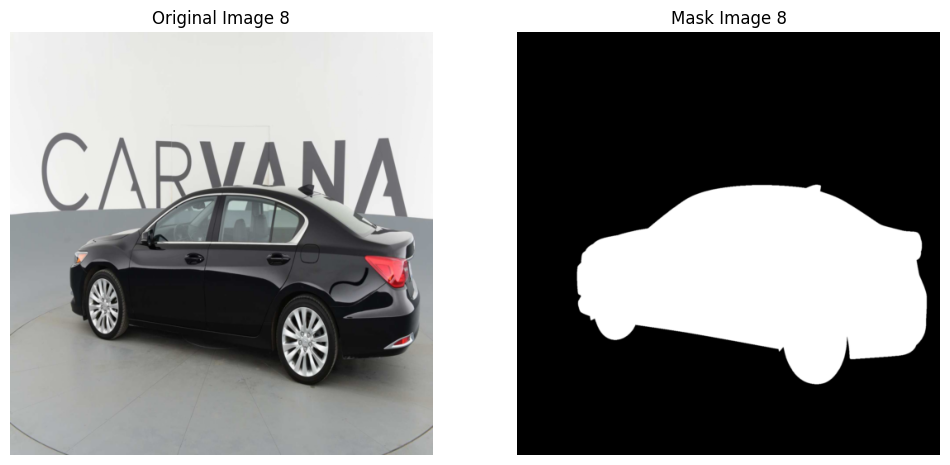

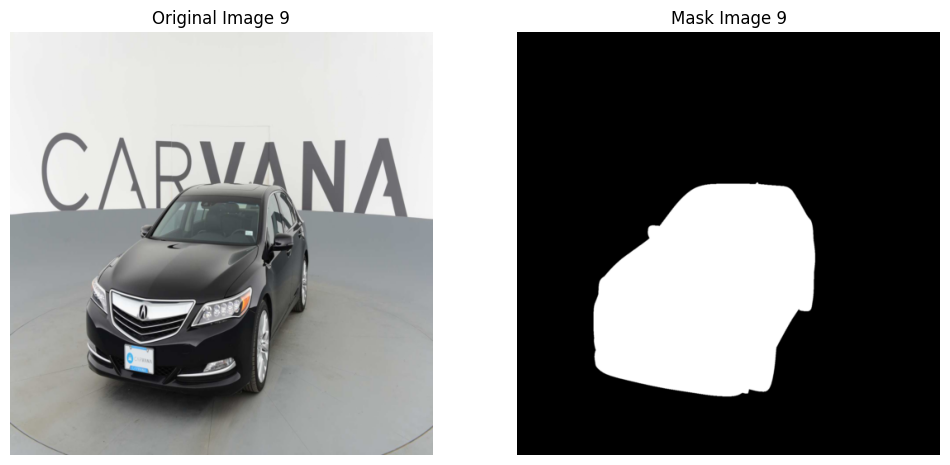

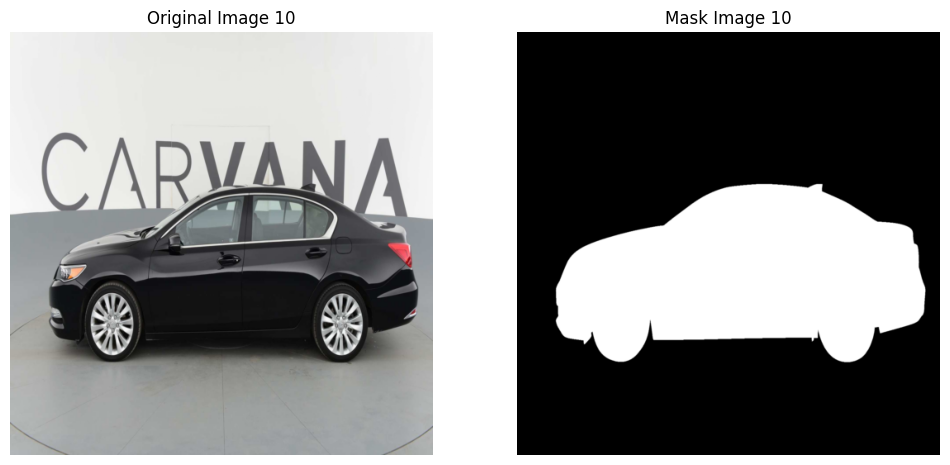

In [82]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Dataset instance
#root_path = '/content/drive/MyDrive/UNet/data'
dataset = CarvanaDataset(root_path, limit=10)

# DataLoader instance
loader = DataLoader(dataset, batch_size=1, shuffle=True)


for i, (images, masks) in enumerate(loader):

    plt.figure(figsize=(12,6))

    #Train Image
    plt.subplot(1, 2, 1)
    plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # Mask Image
    plt.subplot(1, 2, 2)
    plt.imshow(masks[0].squeeze(0).cpu().numpy(), cmap='gray')
    plt.title(f'Mask Image {i+1}')
    plt.axis('off')

    plt.show()



# Trainning

In [84]:
train_dataset = CarvanaDataset(root_path)
generator = torch.Generator().manual_seed(25)

In [85]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator = generator)

In [86]:
test_dataset, val_dataset = random_split(test_dataset, [0.5,0.5], generator = generator)

**Running this experiment with CUDA**

In [93]:
import torch

# CUDA সাপোর্ট আছে কিনা চেক করা
if torch.cuda.is_available():
    print("CUDA is available! Using GPU.")
    # আপনি যদি আপনার GPU এর সংখ্যা দেখতে চান
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
else:
    print("CUDA is not available. Using CPU.")


CUDA is not available. Using CPU.


In [94]:
num_workers = 0
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
  num_workers = torch.cuda.device_count()*4

**Now We setup our model using the AdamW optimizer and the BCEWithLogitsLoss**

In [95]:
Learning_rate = 3e-4
batch_size = 8

train_dataloader = DataLoader(dataset = train_dataset, num_workers = num_workers, pin_memory = False, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, num_workers = num_workers, pin_memory = False, batch_size = batch_size, shuffle = False)
val_dataloader = DataLoader(dataset = val_dataset, num_workers = num_workers, pin_memory = False, batch_size = batch_size, shuffle = False)

mode = UNet(in_channels = 3, num_classes = 1).to(device)
optimizer = optim.AdamW(mode.parameters(), lr = Learning_rate)
criterion = nn.BCEWithLogitsLoss()


**Evaluating Segmentation Performance with DICEMetric**

In [96]:
def dice_coefficient(prediction, target, epsilon=1e-07):
  prediction_copy = prediction.clone()

  prediction_copy[prediction_copy<0] = 0
  prediction_copy[prediction_copy>0] = 1

  intersection = abs(torch.sum(prediction_copy * target))
  union = abs(torch.sum(prediction_copy) + torch.sum(target))
  dice = (2.0 * intersection + epsilon) / (union + epsilon)

  return dice